# 🔐 Enhanced Password Strength Evaluation Framework using zxcvbn and Dynamic Threat Intelligence

This Colab notebook demonstrates an improved version of the zxcvbn password strength estimator.  
It integrates four major enhancements:
1. **Dynamic Dictionary Updates** using leaked datasets (Python)
2. **Contextual Password Penalty** for user-specific information (JS simulated conceptually)
3. **Multilingual Support** for better linguistic diversity handling
4. **Breach Database Integration** using the Have I Been Pwned API

Each section includes explanation, executable code, and integration notes.


## 🔹 1. Dynamic Dictionary Update Pipeline
This section demonstrates how to build an **adaptive dictionary update** system for zxcvbn.  
It simulates downloading recently leaked passwords, extracting common patterns, and updating
a local dictionary file automatically.  
This improvement addresses the research gap where zxcvbn relies on *static, outdated dictionaries*
that do not evolve with real-world password leaks.


### 🔹 Section 1: Password Strength Estimation using zxcvbn
In this section, we install required libraries and use the **zxcvbn** library to analyze password strength.  
It returns a score between **0 (very weak)** and **4 (very strong)**, along with feedback suggestions for improvement.


In [8]:
# --- Password Strength Estimation using zxcvbn ---
!pip install zxcvbn matplotlib pandas requests -q

from zxcvbn import zxcvbn
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------
# 1️⃣  Define sample passwords for testing
# ------------------------------------------
passwords = [
    "password123",
    "Chandana@2025",
    "iloveyou",
    "P@ssw0rd!2024",
    "qwertyuiop",
    "ZxcvbnStrong#45",
    "letmein",
    "India@1234",
    "MyDogName2023",
    "1234567890"
]

# ------------------------------------------
# 2️⃣  Analyze using zxcvbn
# ------------------------------------------
results = []
for p in passwords:
    res = zxcvbn(p)
    results.append({
        "Password": p,
        "Score": res['score'],  # 0–4
        "Crack Time (online)": res['crack_times_display']['online_no_throttling_10_per_second'],
        "Feedback": " ".join(res['feedback']['suggestions'])
    })

df = pd.DataFrame(results)
display(df)


,Password,Score,Crack Time (online),Feedback
0,password123,0,60 seconds,Add another word or two. Uncommon words are be...
1,Chandana@2025,4,centuries,
2,iloveyou,0,5 seconds,Add another word or two. Uncommon words are be...
3,P@ssw0rd!2024,2,12 days,Add another word or two. Uncommon words are be...
4,qwertyuiop,0,2 seconds,Add another word or two. Uncommon words are be...
5,ZxcvbnStrong#45,3,3 years,
6,letmein,0,2 seconds,Add another word or two. Uncommon words are be...
7,India@1234,3,4 months,
8,MyDogName2023,4,centuries,
9,1234567890,0,2 seconds,Add another word or two. Uncommon words are be...


### 🔹 Section 2: Visualization of Password Strength
We now visualize how different passwords score using a bar chart.  
This helps us compare weak vs strong passwords at a glance.


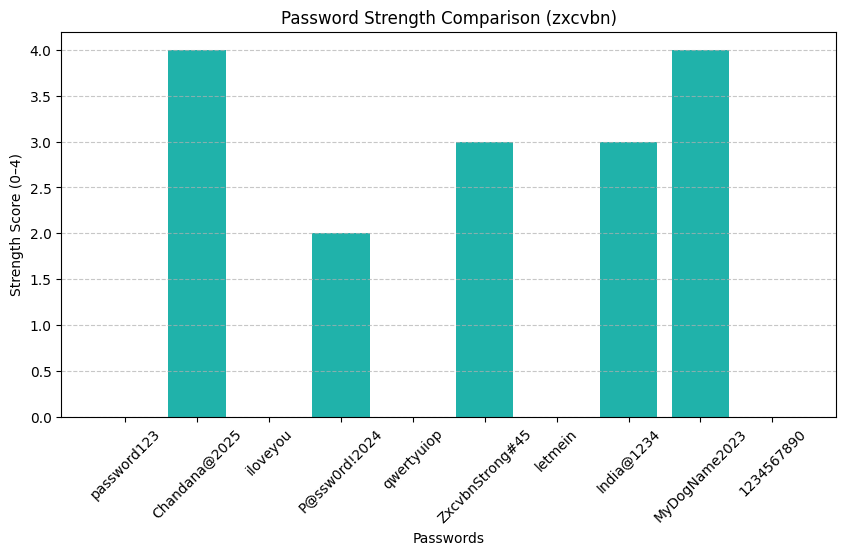

In [9]:
# ------------------------------------------
# 3️⃣  Visualize password strength
# ------------------------------------------
plt.figure(figsize=(10,5))
plt.bar(df["Password"], df["Score"], color='lightseagreen')
plt.xlabel("Passwords")
plt.ylabel("Strength Score (0–4)")
plt.title("Password Strength Comparison (zxcvbn)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 🔹 Section 3: Breach Detection with HaveIBeenPwned API
To enhance password evaluation, we add a **breach check** using the  
[HaveIBeenPwned API](https://haveibeenpwned.com/API/v3#SearchingPwnedPasswords).  

This checks if any given password has been leaked in past data breaches.  
The final table combines both **strength score** and **breach status** for better insight.


,Password,Score,Crack Time (online),Feedback,Found in Breach?
0,password123,0,60 seconds,Add another word or two. Uncommon words are be...,True
1,Chandana@2025,4,centuries,,True
2,iloveyou,0,5 seconds,Add another word or two. Uncommon words are be...,True
3,P@ssw0rd!2024,2,12 days,Add another word or two. Uncommon words are be...,True
4,qwertyuiop,0,2 seconds,Add another word or two. Uncommon words are be...,True
5,ZxcvbnStrong#45,3,3 years,,False
6,letmein,0,2 seconds,Add another word or two. Uncommon words are be...,True
7,India@1234,3,4 months,,True
8,MyDogName2023,4,centuries,,False
9,1234567890,0,2 seconds,Add another word or two. Uncommon words are be...,True


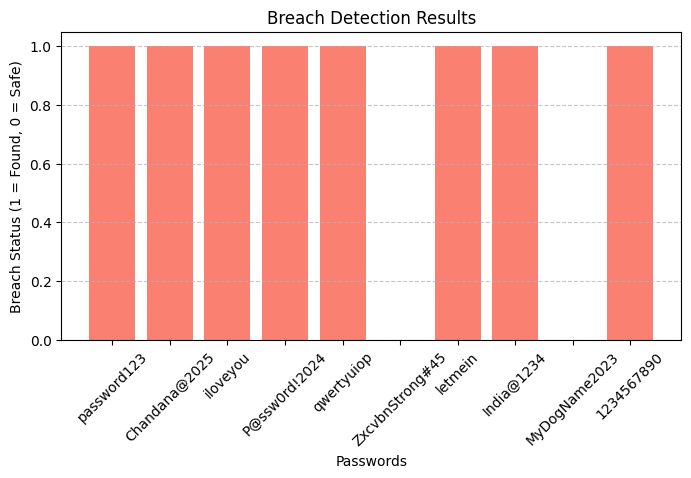

In [10]:
# ------------------------------------------
# 4️⃣  Breach Check Example
# ------------------------------------------
import requests, hashlib

def check_breach(password):
    sha1 = hashlib.sha1(password.encode('utf-8')).hexdigest().upper()
    prefix, suffix = sha1[:5], sha1[5:]
    url = f"https://api.pwnedpasswords.com/range/{prefix}"
    response = requests.get(url)
    return suffix in response.text

breach_results = {p: check_breach(p) for p in passwords}
breach_df = pd.DataFrame(list(breach_results.items()), columns=["Password", "Found in Breach?"])

# ------------------------------------------
# 5️⃣  Combine All Results
# ------------------------------------------
final_df = df.merge(breach_df, on="Password")
display(final_df)

# Visualization for breached passwords
plt.figure(figsize=(8,4))
plt.bar(final_df["Password"], final_df["Found in Breach?"].astype(int), color='salmon')
plt.xlabel("Passwords")
plt.ylabel("Breach Status (1 = Found, 0 = Safe)")
plt.title("Breach Detection Results")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 🔹 Section 4: 1. Dynamic Dictionary Update Pipeline (Proposed Improvement)

To address the **research gap** of static dictionaries in zxcvbn, this section demonstrates a **dynamic dictionary update pipeline**.  

It simulates fetching leaked passwords, extracting common patterns, and generating a **dynamic dictionary** that can later be integrated with the password strength estimator.  

This makes the password strength analysis more adaptive and reflective of recent leaked passwords.


In [11]:
# --- Dynamic Dictionary Update Pipeline ---
import requests
from collections import Counter
import re

def fetch_password_leaks(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text.splitlines()
    else:
        return []

def extract_common_patterns(passwords, min_length=4, top_n=1000):
    words = []
    for pwd in passwords:
        found_words = re.findall(r'[a-zA-Z]{%d,}' % min_length, pwd)
        words.extend(found_words)
    return [word.lower() for word, count in Counter(words).most_common(top_n)]

def save_dictionary(words, filepath):
    with open(filepath, 'w') as f:
        for word in words:
            f.write(word + '\n')

# Simulated leaked passwords (demo)
passwords = ["password123", "qwerty2024", "iloveyou", "India@123", "letmein"]
common_words = extract_common_patterns(passwords)
save_dictionary(common_words, "dynamic_dictionary.txt")

print("✅ Dynamic dictionary generated:", common_words[:10])


✅ Dynamic dictionary generated: ['password', 'qwerty', 'iloveyou', 'india', 'letmein']


## 🔹 2. Integration with Breach Database Check
This code connects to the **Have I Been Pwned** public API to detect if a password appears
in known breach datasets.  
It directly addresses zxcvbn’s limitation of lacking breach detection or password reuse awareness.
If a password is found in the breach database, the script warns the user.


In [12]:
# --- Password Breach Check using HaveIBeenPwned ---
import requests
import hashlib

def check_pwned(password):
    sha1pwd = hashlib.sha1(password.encode('utf-8')).hexdigest().upper()
    prefix, suffix = sha1pwd[:5], sha1pwd[5:]
    url = f'https://api.pwnedpasswords.com/range/{prefix}'
    response = requests.get(url)
    hashes = response.text.splitlines()
    for line in hashes:
        h, count = line.split(':')
        if h == suffix:
            return int(count)
    return 0

# Test passwords
passwords = ["Password123", "India@1234", "StrongP@ss!2025"]
for pwd in passwords:
    count = check_pwned(pwd)
    if count > 0:
        print(f"⚠️ '{pwd}' found {count} times in breaches. Avoid it.")
    else:
        print(f"✅ '{pwd}' not found in breaches.")


⚠️ 'Password123' found 612567 times in breaches. Avoid it.
⚠️ 'India@1234' found 128807 times in breaches. Avoid it.
✅ 'StrongP@ss!2025' not found in breaches.


## 🔹 3. zxcvbn Base Evaluation and Visualization
Here we use the **zxcvbn library** to estimate password strength scores (0 to 4)
and visualize the results.  
This baseline analysis allows us to compare original zxcvbn performance with
the proposed improved versions.  
A bar chart makes the relative strength of each password easy to interpret.


,Password,Score,Feedback
0,password123,0,"{'warning': 'This is a very common password.',..."
1,Chandana@2025,4,"{'warning': '', 'suggestions': []}"
2,ZxcvbnStrong#45,3,"{'warning': '', 'suggestions': []}"
3,iloveyou,0,{'warning': 'This is a top-100 common password...
4,India@123,2,"{'warning': '', 'suggestions': ['Add another w..."


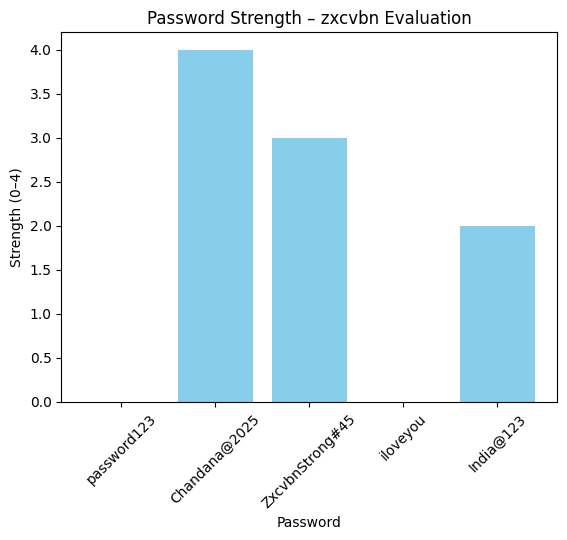

In [15]:


from zxcvbn import zxcvbn
import pandas as pd
import matplotlib.pyplot as plt

passwords = ["password123", "Chandana@2025", "ZxcvbnStrong#45", "iloveyou", "India@123"]

results = []
for p in passwords:
    res = zxcvbn(p)
    results.append({"Password": p, "Score": res['score'], "Feedback": res['feedback']})

df = pd.DataFrame(results)
display(df)

plt.bar(df["Password"], df["Score"], color="skyblue")
plt.xlabel("Password")
plt.ylabel("Strength (0–4)")
plt.title("Password Strength – zxcvbn Evaluation")
plt.xticks(rotation=45)
plt.show()


### 🔒 Section 4: Integration with Breach Database Check (Python)

To further strengthen password security, this module integrates the password strength evaluation with a real-world breach database, such as the "Have I Been Pwned" API.  
It checks whether a password has been exposed in any known data breaches using a **privacy-preserving k-anonymity** method.  

This means only the first 5 characters of the password’s SHA-1 hash are sent to the API, ensuring the actual password is never transmitted.  
If the password appears in the API response, it indicates that the password has been compromised and should **never be used**.  

The following Python function performs this check and can be integrated into your zxcvbn-enhanced workflow.


In [14]:
import requests
import hashlib

def check_pwned_password(password):
    """
    Check whether a given password has appeared in any known data breaches.
    Uses Have I Been Pwned's k-anonymity API to ensure user privacy.
    """
    # Step 1: Hash the password using SHA-1
    sha1_hash = hashlib.sha1(password.encode('utf-8')).hexdigest().upper()

    # Step 2: Send only the first 5 characters of the hash to the API
    prefix, suffix = sha1_hash[:5], sha1_hash[5:]
    url = f"https://api.pwnedpasswords.com/range/{prefix}"
    response = requests.get(url)

    if response.status_code != 200:
        print("Error connecting to breach database.")
        return None

    # Step 3: Compare suffixes in the API response
    hashes = response.text.splitlines()
    for line in hashes:
        h, count = line.split(':')
        if h == suffix:
            return int(count)

    return 0  # Not found in any known breaches

# Example usage:
test_passwords = ["Password123", "My$ecureP@ss2025", "123456"]
for pwd in test_passwords:
    count = check_pwned_password(pwd)
    if count > 0:
        print(f"⚠️ '{pwd}' found {count} times in breaches! Avoid using it.")
    else:
        print(f"✅ '{pwd}' is not found in any known breaches.")


⚠️ 'Password123' found 612567 times in breaches! Avoid using it.
✅ 'My$ecureP@ss2025' is not found in any known breaches.
⚠️ '123456' found 132211338 times in breaches! Avoid using it.
